# Tutorial 5: Integrating MOB data from Stereo-seq and Slide-seqV2
This tutorial demonstrates SMILE's ablility to integrate two SRT data coming from Stereo-seq and Slide-seqV2. The processed data can be downloaded from https://figshare.com/articles/dataset/spatial_transcriptomics_data_and_scRNA-seq_data_of_MOB/27997628

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from stSMILE import SMILE

In [3]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squidpy as sq
import scipy.sparse as sp
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from itertools import chain
from scanpy import read_10x_h5
import torch.optim as optim
import sklearn
from sklearn.neighbors import kneighbors_graph
import gudhi
import networkx as nx
from torch_geometric.nn import GCNConv
import random
import os
import json 
import matplotlib.image as mpimg

# load data

In [4]:
section_ids = ['Stereo-seq','Slide-seqV2']
print(section_ids)

['Stereo-seq', 'Slide-seqV2']


In [5]:
adata_l = []
for i in range(len(section_ids)):
    adata_i = sc.read_h5ad('/Users/lihuazhang/Documents/SMILE-main/dataset/MOB/MOB_'+ section_ids[i]+'_ST_final.h5ad')
    adata_l.append(adata_i)

In [6]:
# load sc data
adata0_sc = sc.read_h5ad('/Users/lihuazhang/Documents/SMILE-main/dataset/MOB/MOB_sc_final.h5ad')

In [7]:
adata0_sc

AnnData object with n_obs × n_vars = 9855 × 2373
    obs: 'X', 'nGene', 'nUMI', 'orig.ident', 'experiment', 'percent.mito', 'res.1.6', 'ClusterName', 'n_genes', 'ref'
    var: 'n_cells'
    uns: 'rank_genes_groups'
    obsp: 'adj_f'

In [8]:
cell_subclass = list(set(adata0_sc.obs['ClusterName'].tolist()))

In [9]:
label0_list = list(set(adata0_sc.obs['ClusterName'].tolist()))

In [10]:
# define ref as new label used 
adata0_label_new = adata0_sc.obs['ClusterName'].tolist()

for i in range(len(label0_list)):
    need_index = np.where(adata0_sc.obs['ClusterName'] == label0_list[i])[0]    
    if len(need_index):
        for p in range(len(need_index)):
            adata0_label_new[need_index[p]] = i  

In [11]:
adata0_sc.obs['ref'] = pd.Series(adata0_label_new, index = adata0_sc.obs['ClusterName'].index)

In [12]:
adata0_sc.obs['Ground Truth'] = adata0_sc.obs['ClusterName']

In [13]:
adata_l.append(adata0_sc)

In [14]:
np.min(adata0_sc.X)

0.0

# Run SMILE

In [15]:
in_features = len(adata_l[0].var.index)
hidden_features = 512
out_features = 50

In [16]:
tag_l = ['ST','ST','single cell']

In [17]:
feature_method = 'GCNConv'
alpha = 0.001
beta = 1 
lamb = 0.01 
theta = 0.001 
gamma = 10 # reconstruct 
spatial_regularization_strength= 0.9
lr=1e-3
subepochs=100
epochs=200
max_patience=50
min_stop=20
random_seed=2024
gpu=0
regularization_acceleration=True
edge_subset_sz=1000000

In [18]:
add_topology = True
add_feature = False
add_image = False
add_sc = True

In [19]:
multiscale = True

In [20]:
anchor_type = None
anchors_all = True
use_rep_anchor = 'embedding'
anchor_size=5000

In [24]:
iter_comb= None
edge_weights = [1,0.1,0.1]
n_clusters_l = [10]

In [25]:
class_rep = 'reconstruct'

In [26]:
adata_l = SMILE(adata_l, tag_l, section_ids, multiscale,  n_clusters_l, in_features, feature_method, hidden_features, out_features, iter_comb, anchors_all, use_rep_anchor, alpha, beta, lamb, theta, gamma,edge_weights, add_topology, add_feature, add_image, add_sc, spatial_regularization_strength, lr=lr, subepochs=subepochs, epochs=epochs, class_rep = class_rep)

Pretraining to extract embeddings of spots...
epoch   0: train spatial C loss: 0.0000, train F loss: 1.3654,
epoch  10: train spatial C loss: 0.0000, train F loss: 1.0638,
epoch  20: train spatial C loss: 0.0000, train F loss: 1.0345,
epoch  30: train spatial C loss: 0.0000, train F loss: 1.0142,
epoch  40: train spatial C loss: 0.0000, train F loss: 1.0102,
epoch  50: train spatial C loss: 0.0000, train F loss: 0.9805,
epoch  60: train spatial C loss: 0.0000, train F loss: 0.9778,
epoch  70: train spatial C loss: 0.0000, train F loss: 0.9660,
epoch  80: train spatial C loss: 0.0000, train F loss: 0.9554,
epoch  90: train spatial C loss: 0.0000, train F loss: 0.9513,
Training classifier...
Training classifier...
torch.Size([18109, 40])
torch.Size([14154, 40])
epoch   0: overall loss: 3.8557,sc classifier loss: 3.7134,representation loss: 0.0142,within spatial regularization loss: 0.1307
torch.Size([18109, 40])
torch.Size([14154, 40])
torch.Size([18109, 40])
torch.Size([14154, 40])
torc

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Identifying anchors...
Processing datasets (0, 1)
Aligning by anchors...
epoch 100: total loss:1.0212, train F loss: 0.9570, train C loss: 2.2820, train D loss: 0.0641
epoch 110: total loss:0.9978, train F loss: 0.9584, train C loss: 1.1480, train D loss: 0.0394
epoch 120: total loss:0.9847, train F loss: 0.9503, train C loss: 0.9109, train D loss: 0.0343
epoch 130: total loss:0.9812, train F loss: 0.9489, train C loss: 0.7977, train D loss: 0.0323
epoch 140: total loss:0.9663, train F loss: 0.9349, train C loss: 0.7232, train D loss: 0.0315
epoch 150: total loss:0.9630, train F loss: 0.9324, train C loss: 0.6724, train D loss: 0.0306
epoch 160: total loss:0.9588, train F loss: 0.9291, train C loss: 0.6357, train D loss: 0.0297
epoch 170: total loss:0.9585, train F loss: 0.9292, train C loss: 0.5975, train D loss: 0.0292
epoch 180: total loss:0.9555, train F loss: 0.9267, train C loss: 0.5719, t

In [29]:
adata_concat_st = ad.concat(adata_l[0:len(section_ids)], label="slice_name", keys=section_ids)

In [30]:
sc.tl.pca(adata_concat_st)
adata_concat_st.obsm['X_pca_old'] = adata_concat_st.obsm['X_pca'].copy()
adata_concat_st.obsm['X_pca'] = adata_concat_st.obsm['embedding'].copy()
sc.pp.neighbors(adata_concat_st)  
sc.tl.umap(adata_concat_st)

In [31]:
sc.tl.leiden(adata_concat_st, random_state=666, key_added="leiden", resolution=0.35)
len(list(set(adata_concat_st.obs['leiden'].tolist())))

8

In [40]:
from stSMILE import analysis
analysis.mclust_R(adata_concat_st, num_cluster=10, used_obsm="embedding")

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 32263 × 2373
    obs: 'n_genes', 'pd_cluster', 'slice_name', 'leiden', 'mclust'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'mclust_colors', 'slice_name_colors'
    obsm: 'spatial', 'embedding', 'hidden_spatial', 'reconstruct', 'deconvolution', 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

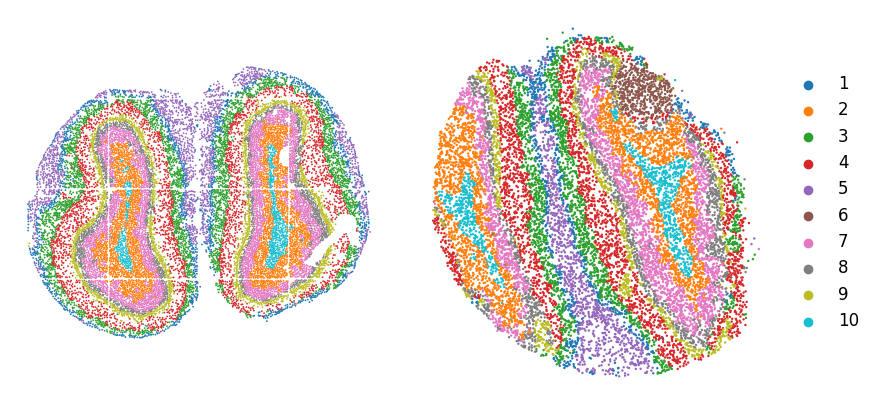

In [42]:
# split to each data
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat_st[adata_concat_st.obs['slice_name'] == section_id])


import matplotlib.pyplot as plt
spot_size = 30
title_size = 12

fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
#_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc='right margin', legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
#_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
plt.savefig("MOB_SMILE_mclust.pdf") 
plt.show()

In [43]:
# write out the result
for i in range(len(section_ids)):
    adata_i = adata_l[i].copy()
    ot_i = adata_i.uns['deconvolution']
    ot_i.to_csv('MOB_SMILE_'+ section_ids[i]+'.csv', sep='\t')
    del adata_i.uns['deconvolution']
    del adata_i.uns['deconvolution_pre']
    adata_i.write('MOB_SMILE_'+ section_ids[i]+'_ST.h5ad')
    del adata_i

In [44]:
adata_i = adata_l[len(section_ids)].copy()
adata_i.write('MOB_SMILE_'+ section_ids[i]+'_sc.h5ad')

In [45]:
for i in range(len(section_ids)):
    adata_i = adata_l[i].copy()
    df_spa = pd.DataFrame(adata_i.obsm['spatial'], index = adata_i.obs_names, columns = ['x','y'])
    df_spa.to_csv('MOB_'+ section_ids[i]+'_spatial.csv', sep='\t')